In [225]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [226]:
!pip install lightGBM

In [227]:
import gc
gc.collect()

14706

In [228]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
is_denso = True
train_path = '/home/hayato/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
if is_denso:
    train_path = '/home/denso/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
train_data = pd.read_csv(train_path, encoding='utf-8')
train_data_for_ranking = train_data.copy()
print("train data length {}".format(len(train_data)))

train data length 741498


In [229]:
from pathlib import Path
import pandas as pd
import tqdm
def read_csv_data(train_path):
    # csvデータを読み込み、1行にまとめる
    p = Path(train_path)
    files = list(p.glob("inference*.csv"))
    df = pd.DataFrame()
    for i, file in tqdm.tqdm(enumerate(files)):
        race_csv_data = pd.read_csv(file, encoding='utf-8')
        # 各CSVファイルのデータを1行にまとめる
        race_csv_data = race_csv_data.sum(axis=0).to_frame().T
        
        # データフレームに追加
        df = pd.concat([df, race_csv_data], ignore_index=True)
    return df

inference_data = "/home/hayato/keiba_analysis/inference/2024070402/"
if is_denso:
    inference_data = "/home/denso/keiba_analysis/inference/2024070402/"
inference_data = read_csv_data(inference_data)
inference_data

0it [00:00, ?it/s]


""


In [230]:
train_data


,Unnamed: 0,target_no1_umaban,date,race_name,place,class_list_in_race,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds,goal_number
0,0,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",シゲルダイノウカイ,1,2,0,462,4,54.0,小原義之,7.0,2
1,1,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スイートゴールド,2,2,1,-14,-14,53.0,藤岡佑介,81.6,10
2,2,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スズカイエロー,3,2,0,500,-2,54.0,蛯名正義,2.3,6
3,3,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",インザリピート,4,2,1,448,-8,54.0,松永幹夫,74.4,8
4,4,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",テイエムヒスイ,5,2,1,432,-18,54.0,秋山真一,3.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741493,741493,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",トロハ,12,3,1,468,2,52.0,武豊,17.5,15
741494,741494,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",サダムラピュタ,13,4,0,486,12,57.0,秋山真一,7.7,5
741495,741495,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",バイマイサイド,14,4,0,484,18,57.0,浜中俊,4.4,1
741496,741496,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",シエラネバダ,15,4,0,504,-2,57.0,松山弘平,21.9,3


In [231]:
train_data.describe()

,Unnamed: 0,target_no1_umaban,date,number_of_horses,distance,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,odds,goal_number
count,741498.000000,741498.00000,7.414980e+05,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000
mean,370748.500000,7.87469,2.012057e+09,14.783031,1642.615530,7.891516,3.656019,0.449531,469.330962,0.254822,55.058424,67.459365,7.891516
std,214052.179289,4.44242,4.293032e+06,2.302275,432.645537,4.460383,1.349710,0.563194,36.993146,6.557119,1.782221,96.571090,4.460383
min,0.000000,1.00000,2.005010e+09,4.000000,1000.000000,1.000000,2.000000,0.000000,-26.000000,-54.000000,47.000000,1.000000,1.000000
25%,185374.250000,4.00000,2.008101e+09,14.000000,1200.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,8.700000,4.000000
50%,370748.500000,8.00000,2.012062e+09,16.000000,1600.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,25.900000,8.000000
75%,556122.750000,11.00000,2.016031e+09,16.000000,1800.000000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,84.200000,11.000000
max,741497.000000,18.00000,2.019123e+09,18.000000,4260.000000,18.000000,13.000000,2.000000,640.000000,60.000000,66.000000,999.900000,18.000000


In [232]:
# 前処理
def preprocess(train_data):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    train_data = train_data.drop(['Unnamed: 0','target_no1_umaban', 'class_list_in_race'], axis=1)
    # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない
    train_data['goal_number'] = train_data['goal_number'].replace([1], 0)
    train_data['goal_number'] = train_data['goal_number'].replace([2,3], 1)
    train_data['goal_number'] = train_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 2)
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    train_data.columns = train_data.columns.str.replace(":", "_")
    train_data.columns = train_data.columns.str.replace(",", "_")
    train_data.columns = train_data.columns.str.replace("'", "_")
    train_data.columns = train_data.columns.str.replace('"', "_")
    train_data.columns = train_data.columns.str.replace(" ", "_")
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    train_data = train_data[30000:]
    return train_data

train_data = preprocess(train_data)

In [233]:
# inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
# object型の特長量を確認する
object_columns = inference_data.select_dtypes(include='object').columns
object_columns
for column in object_columns:
    le = LabelEncoder()
    inference_data[column] = le.fit_transform(inference_data[column])

In [234]:
# train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

In [235]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [236]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [237]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [238]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 398438
valid data length 99610
test data length 213450
train data length 398438
valid data length 99610
test data length 213450


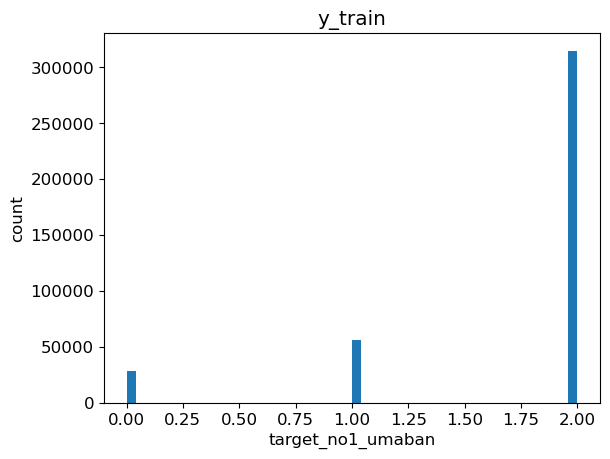

77076     0
731534    2
726246    2
333464    2
253761    2
         ..
203527    2
599382    1
565983    2
92360     2
110783    2
Name: goal_number, Length: 398438, dtype: int64


In [239]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [240]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[4.7707415  0.42167705 0.42167705 ... 0.42167705 0.42167705 0.42167705]
[1. 1. 1. ... 1. 1. 1.]


In [241]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [242]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [243]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: race_name: object, place: object, condition: object, horse_name_: object, jocky: object

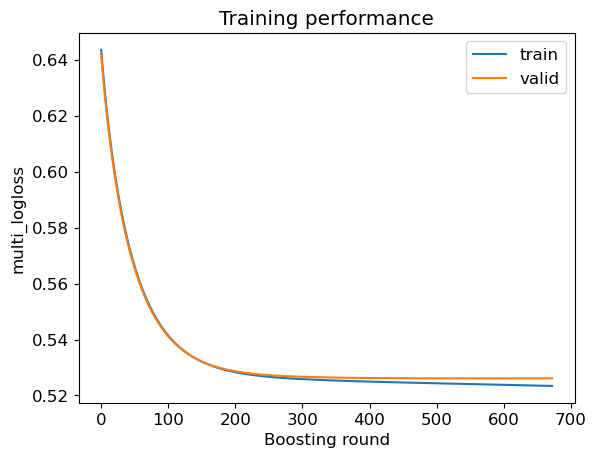

In [215]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [216]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.009295  0.047630  0.943076
1  0.081011  0.243458  0.675530
2  0.237127  0.357062  0.405811
3  0.048007  0.137901  0.814091
4  0.067554  0.215200  0.717246
0        0.009295
1        0.081011
2        0.237127
3        0.048007
4        0.067554
           ...   
99605    0.019849
99606    0.005531
99607    0.009648
99608    0.006570
99609    0.006782
Name: 0, Length: 99610, dtype: float64


In [217]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        2
1        2
2        2
3        2
4        2
        ..
99605    2
99606    2
99607    2
99608    2
99609    2
Length: 99610, dtype: int64

In [218]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

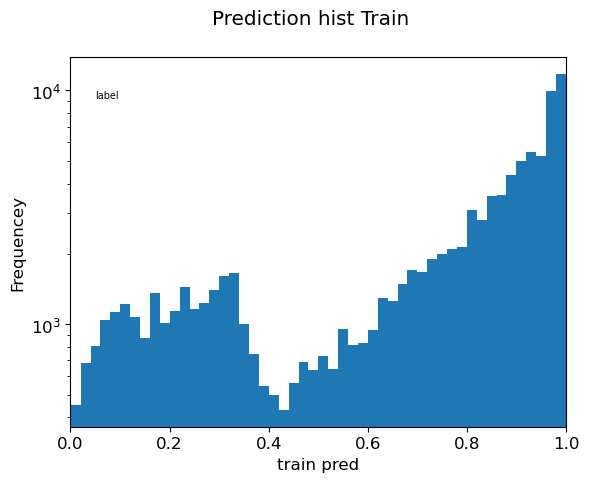

In [219]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [220]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

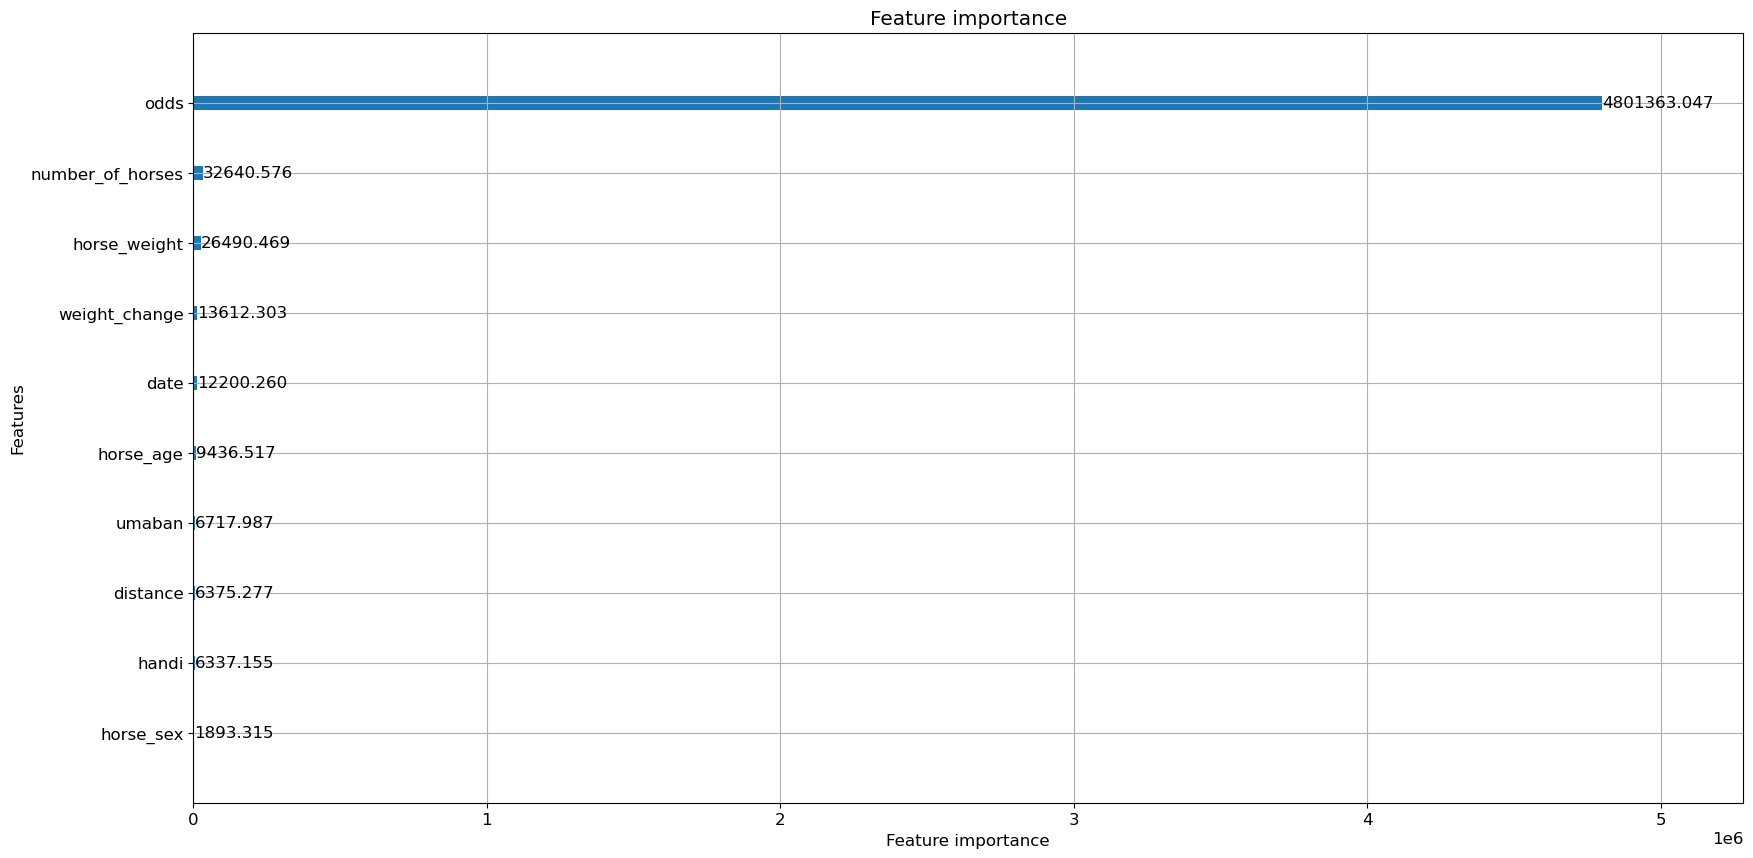

In [221]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7967473145266538


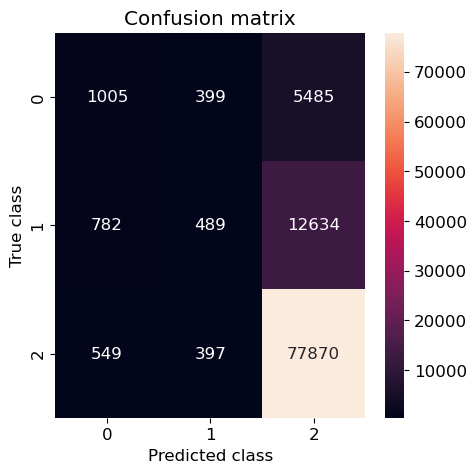

In [222]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7967473145266538


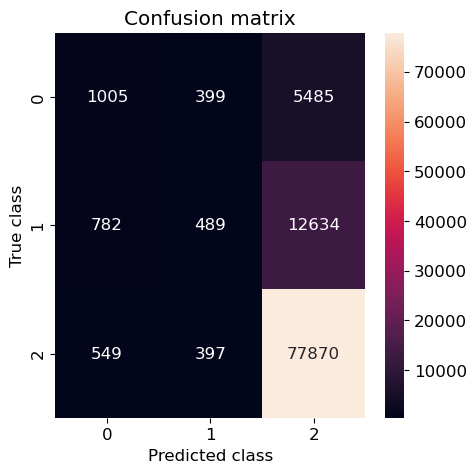

In [223]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


In [224]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

inference test data and compare with test correct data


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: race_name: object, place: object, condition: object, horse_name_: object, jocky: object

In [194]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割
train_ranking, test_ranking = train_test_split(train_data_for_ranking, test_size=0.3, random_state=42)
# ランキング学習用のtrain dataを7:3で分割
train_ranking, valid_ranking = train_test_split(train_ranking, test_size=0.3, random_state=42)

def create_query(df, name='train'):
    # データの先頭を表示して確認
    print("DataFrame head:")
    print(df.head())

    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    print(df[['date', 'race_name', 'place', 'number_of_horses', 'distance']].drop_duplicates().head())

    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['date', 'race_name', 'place', 'number_of_horses', 'distance']).size().reset_index(name='horse_count')

    # date列を降順にソート
    race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の新しい順にソート
    sorted_df = df.set_index(['date', 'race_name', 'place', 'number_of_horses', 'distance']).sort_index(level='date', ascending=False).reset_index()

    # ソートされた特徴量データの表示
    print("\nSorted feature data:")
    print(sorted_df.head())
    # ソートデータの保存
    sorted_df.to_csv("sorted_{}_data.csv".format(name), index=False)
    return horse_counts_list, sorted_df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")


DataFrame head:
             date  race_name  place  number_of_horses  distance  condition  \
30000  2005121100         26    192                16      1700          0   
30001  2005121100         26    192                16      1700          0   
30002  2005121100         26    192                16      1700          0   
30003  2005121100         26    192                16      1700          0   
30004  2005121100         26    192                16      1700          0   

       horse_name_  umaban  horse_age  horse_sex  horse_weight  weight_change  \
30000        20399      12          3          0           498              0   
30001         8378      13          3          0           486              8   
30002        47493      14          3          0           492              8   
30003        61185      15          3          1           448             -8   
30004        61588      16          5          0           484              8   

       handi  jocky   odds  

In [ ]:
# y込でソートしたので、ここでyを目的変数に設定して削除する
y_train_ranking = sorted_train_data['goal_number']
y_valid_ranking = sorted_valid_data['goal_number']
X_sorted_train_data = sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = sorted_valid_data.drop('goal_number', axis=1)
y_test_true_ranking = test_ranking['goal_number']

In [ ]:
# クエリを取得したので前処理をかける
sorted_train_data = preprocess(X_sorted_train_data)
sorted_valid_data = preprocess(X_sorted_valid_data)
test_ranking = preprocess(test_ranking)

In [192]:
############ real inference ############
print("real inference")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(inference_data)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)
print(y_pred.head())
print(y_pred[0])
print(y_pred_submit)


real inference


ValueError: Input data must be 2 dimensional and non empty.